Source(s): 

https://catalog.data.gov/dataset/inmates-under-custody-beginning-2008

<h3> Purpose </h3>
The primary purpose of this analysis is to look at the many details of the criminal justice system, starting with the state of New York, then expanding the scope to other datasets for additional analysis as part of a set. This analysis is looking to find counter-intuitive data that would be cause for concern, as well as to understand larger trends occurring. While this data will likely point towards generalized conclusions and data-driven statements, the purpose is not to answer all the possible questions or propose solutions in any way, as these issues are far larger than what this data could reasonably cover.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

<h1> New York State </h1>

<h2>Data Verification & Handling</h2>

In [10]:
df = pd.read_csv('NY State/Incarcerated_Individuals_Under_Custody_Beginning_2008.csv', low_memory=False)
df.isnull().sum().sort_values(ascending=False)

Race/Ethnicity             61675
Snapshot Year                  0
Latest Admission Type          0
County of Indictment           0
Gender                         0
Most Serious Crime             0
Current Age                    0
Housing Facility               0
Facility Security Level        0
dtype: int64

Since Race/Ethnicity isn't something we can guess at, we'll simply set these to 'UNKNOWN' so the entries are simply excluded from any statistics based upon this. This matches up with how the initial dataset handles unknowns in this area. Fortunately this is the only field with null values, and they are only ~4% of the dataset that only applies to specific analysis.

In [11]:
df['Race/Ethnicity'] = df['Race/Ethnicity'].fillna('UNKNOWN')
df.isnull().sum().sort_values(ascending=False)
plt.rcParams["font.size"] = "16"
# During work on the dataset, it was noted two forms of 'Medium Security' exist. Combining them.
df.replace('MEDIUM SECURITY', 'MEDIUM  SECURITY', inplace = True);

<h1>Data Analysis</h1>

<h3>General Analyses</h3>

As seen below, convictions have been on a steady decline so far. This data was last updated on November 29th, 2021, so while 2021 is not over, it is rather close to being so, and looks like it will continue to maintain the general trend.

I'd like to note that this is in contradiction to what you may read or see in media. The key point here, in my opinion, is that this data focuses on long-term trends for the whole state, not cherrypicking specific counties, towns, or otherwise, where specific circumstances may play a bigger role.

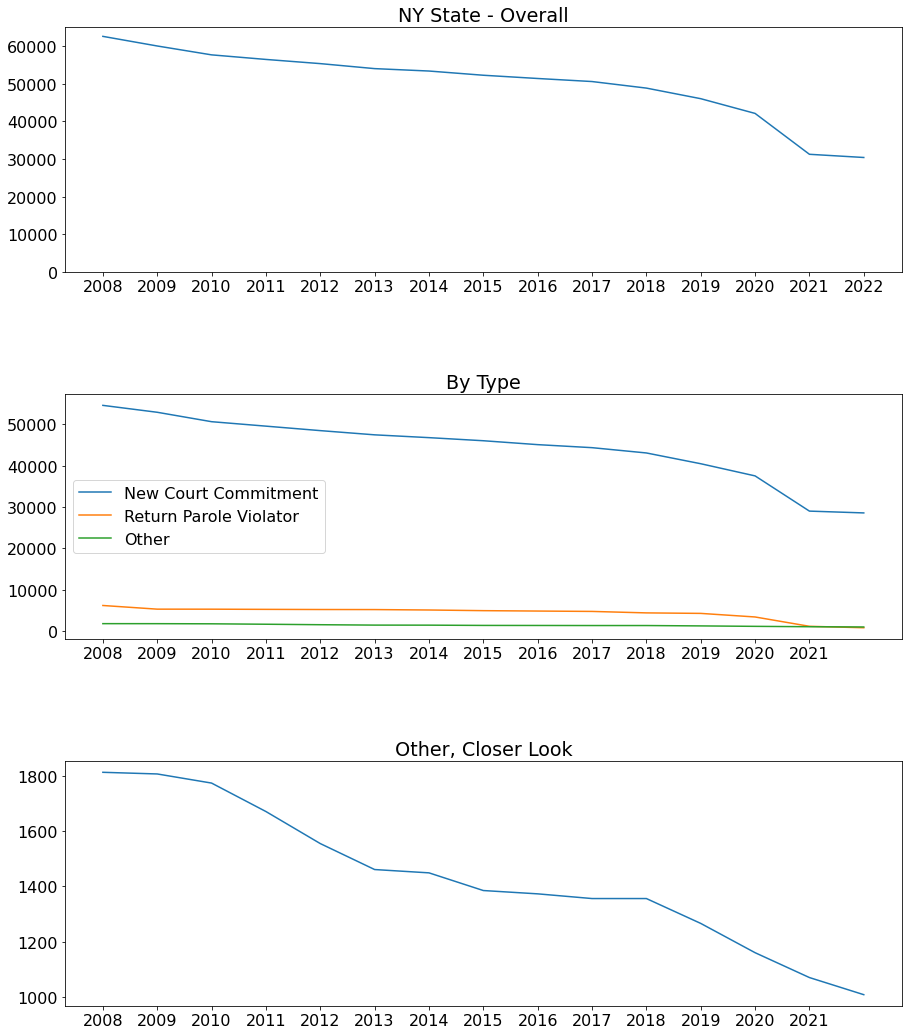

In [12]:
fig = plt.figure(figsize = (15,18))
grid = plt.GridSpec(3,1, hspace = 0.5, wspace = 0.3, figure = fig)
barbin = np.arange(2008, 2023, 0.5)
linbin = np.arange(2008, 2023, 1)

fig.add_subplot(grid[0,0], title = "NY State - Overall")
plt.xticks(range(2008, 2023, 1))
plt.ylim(0,65000)
plt.plot(linbin, df['Snapshot Year'].value_counts())

admissions = df.groupby('Latest Admission Type')
newcom = admissions.get_group('NEW COURT COMMITMENT')
retcom = admissions.get_group('RET PAROLE VIOLATOR')
othcom = admissions.get_group('OTHER')

fig.add_subplot(grid[1,0], title = "By Type")
plt.xticks(range(2008, 2022, 1))
plt.plot(linbin, newcom['Snapshot Year'].value_counts(), label = 'New Court Commitment')
plt.plot(linbin, retcom['Snapshot Year'].value_counts(), label = 'Return Parole Violator')
plt.plot(linbin, othcom['Snapshot Year'].value_counts(), label = 'Other')
plt.legend()

fig.add_subplot(grid[2,0], title = "Other, Closer Look")
plt.xticks(range(2008, 2022, 1))
plt.plot(linbin, othcom['Snapshot Year'].value_counts());

The following covers the overall total types of sentences, as well as looks at several generalized statistics we'll look more closely at later. Notably, the racial and gender disparities we hear about in media seem to be echoed here, though perhaps not to such an extreme as made out to be by some in some of these cases, it is still very concerning.

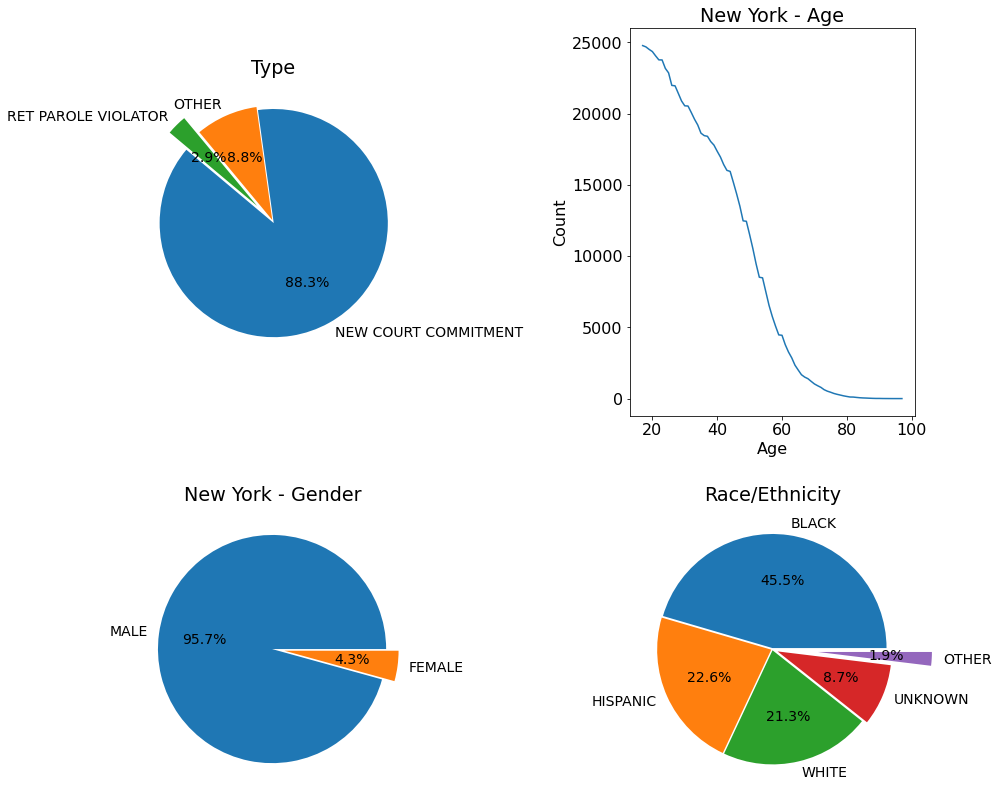

In [13]:
fig = plt.figure(figsize = (23,15))
grid = plt.GridSpec(2,3, hspace = 0.1, wspace = 0.75, figure = fig)


fig.add_subplot(grid[0,0], title = "Type")
plt.pie(df['Latest Admission Type'].value_counts(), labels = pd.unique(df['Latest Admission Type']), autopct='%1.1f%%', textprops={'fontsize': 14}, explode = (0.01, 0.02, 0.2), startangle = 140)

fig.add_subplot(grid[0,1], title = "New York - Age", xlabel = 'Age', ylabel = 'Count')
plt.plot(range(df['Current Age'].min() + 1, df['Current Age'].max() - 1, 1), df['Current Age'].value_counts());

fig.add_subplot(grid[1,0], title = "New York - Gender")
plt.pie(df['Gender'].value_counts(), labels = df['Gender'].value_counts().keys(), autopct='%1.1f%%', textprops={'fontsize': 14}, explode = (0.01, 0.1));

fig.add_subplot(grid[1,1], title = "Race/Ethnicity")
plt.pie(df['Race/Ethnicity'].value_counts(), labels = df['Race/Ethnicity'].value_counts().keys(), autopct='%1.1f%%', textprops={'fontsize': 14}, explode = (0.01, 0.01, 0.01, 0.05, 0.4));

The top two graphs are unsurprising and match general expectations. That said, we'll briefly take a look at more detailed age-based statistics as well. Not sure what 'Other' means, though the simplest assumption is that it's a whole lot of things that would otherwise be a large number of small categories.

The male/female disparity is surprisingly large, and the race disparity is similarly massive. For this reason, we'll take a closer look at these two statistics later.

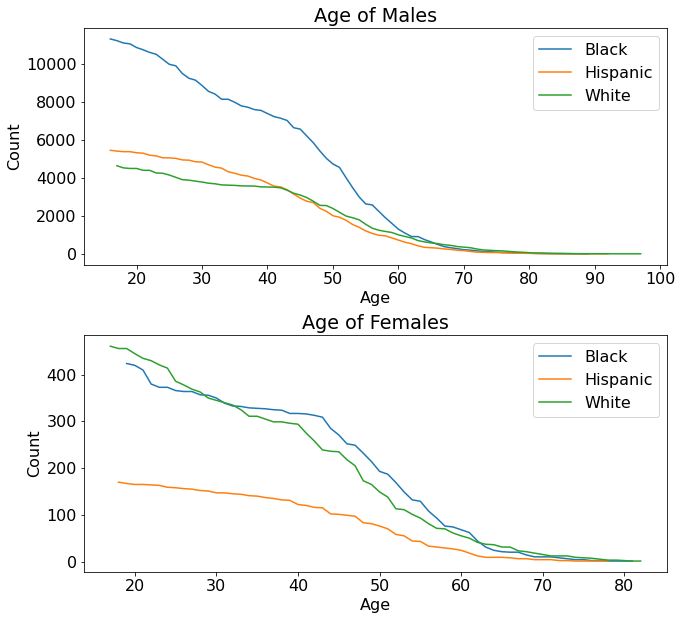

In [14]:
genders = df.groupby('Gender')
male = genders.get_group('MALE')
female = genders.get_group('FEMALE')

maleRaces = male.groupby('Race/Ethnicity')
femaleRaces = female.groupby('Race/Ethnicity')

blackMale = maleRaces.get_group('BLACK')
hispanicMale = maleRaces.get_group('HISPANIC')
whiteMale = maleRaces.get_group('WHITE')

blackFemale = femaleRaces.get_group('BLACK')
hispanicFemale = femaleRaces.get_group('HISPANIC')
whiteFemale = femaleRaces.get_group('WHITE')

fig = plt.figure(figsize = (23,10))
grid = plt.GridSpec(2,2, hspace = 0.3, wspace = 0.2, figure = fig)

fig.add_subplot(grid[0,0], title = 'Age of Males', xlabel = 'Age', ylabel = 'Count')
plt.plot(range(blackMale['Current Age'].min(), blackMale['Current Age'].max() + 1, 1), blackMale['Current Age'].value_counts(), label = 'Black')
plt.plot(range(hispanicMale['Current Age'].min(), hispanicMale['Current Age'].max() + 1, 1), hispanicMale['Current Age'].value_counts(), label = 'Hispanic')
plt.plot(range(whiteMale['Current Age'].min() + 1, whiteMale['Current Age'].max() - 1, 1), whiteMale['Current Age'].value_counts(), label = 'White')
plt.legend()

fig.add_subplot(grid[1,0], title = 'Age of Females', xlabel = 'Age', ylabel = 'Count')
plt.plot(range(blackFemale['Current Age'].min() + 2, blackFemale['Current Age'].max() - 3, 1), blackFemale['Current Age'].value_counts(), label = 'Black')
plt.plot(range(hispanicFemale['Current Age'].min() + 2, hispanicFemale['Current Age'].max() - 2, 1), hispanicFemale['Current Age'].value_counts(), label = 'Hispanic')
plt.plot(range(whiteFemale['Current Age'].min(), whiteFemale['Current Age'].max(), 1), whiteFemale['Current Age'].value_counts(), label = 'White')
plt.legend();

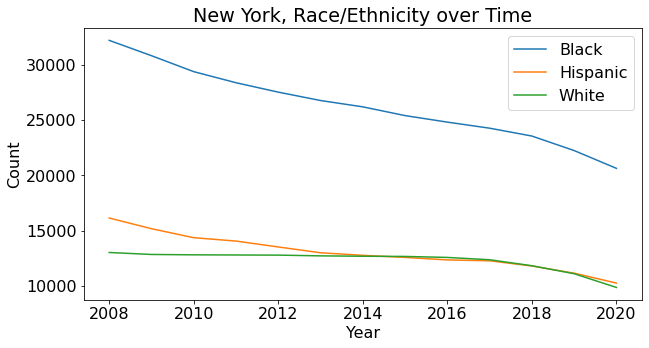

In [15]:
linbin = np.arange(2008, 2021, 1)
fig = plt.figure(figsize = (10,5))
grid = plt.GridSpec(1,1, hspace = 0.3, wspace = 0.3, figure = fig)

ethnicity = df.groupby('Race/Ethnicity')
black = ethnicity.get_group('BLACK')
hispanic = ethnicity.get_group('HISPANIC')
white = ethnicity.get_group('WHITE')

fig.add_subplot(grid[0:,0], title = "New York, Race/Ethnicity over Time", xlabel = "Year", ylabel = "Count")
plt.plot(linbin, black['Snapshot Year'].value_counts(), label = 'Black')
plt.plot(linbin, hispanic['Snapshot Year'].value_counts(), label = 'Hispanic')
plt.plot(linbin, white['Snapshot Year'].value_counts(), label = 'White')
plt.legend();

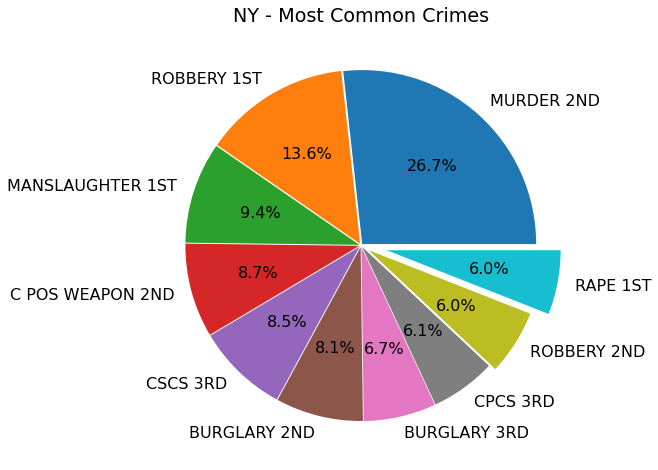

In [16]:
fig = plt.figure(figsize = (20,8))
grid = plt.GridSpec(1,1, hspace = 0.5, wspace = 0.3, figure = fig)
topCrimes = df['Most Serious Crime'].value_counts().head(10)

fig.add_subplot(grid[0:,0], title = 'NY - Most Common Crimes')
plt.pie(topCrimes, labels = topCrimes.keys(), autopct='%1.1f%%', textprops={'fontsize': 16}, explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.05, 0.15));


- ATT = Attempted (Just to be clear)
- CSCS = Criminal Sale of a Controlled Substance (Drugs)
- CPCS = Criminal Possession of a Controlled Substance (Drugs)
- C POS WEAPON = Criminal Possession of a Weapon

These ten crimes total 326,068 of all the 722,087 records in this dataset. So, approximately, 45% of all the crimes that result in jail/prison time.

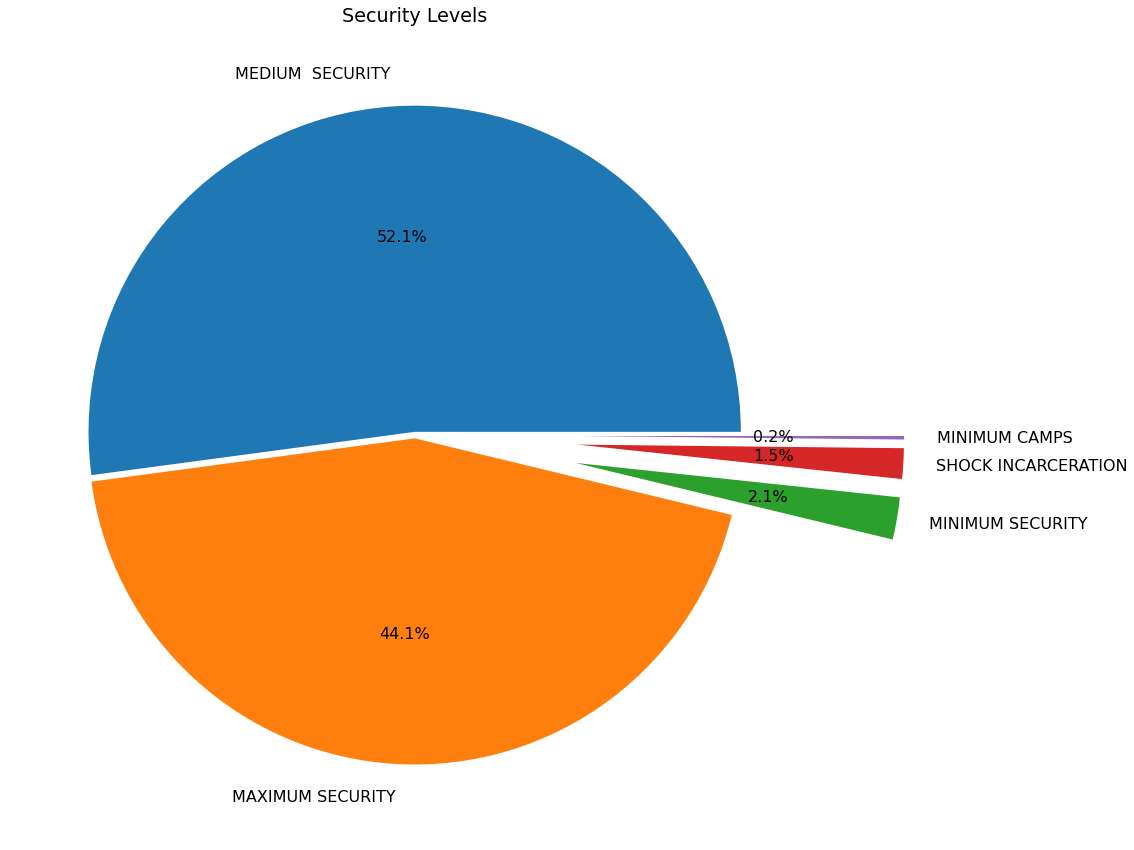

In [17]:
fig = plt.figure(figsize = (20,15))
grid = plt.GridSpec(1,1, hspace = 0.5, wspace = 0.3, figure = fig)
security = df['Facility Security Level'].value_counts()

fig.add_subplot(grid[0:,0], title = 'Security Levels')
plt.pie(security, labels = security.keys(), autopct='%1.1f%%', explode = (0.01, 0.01, 0.5, 0.5, 0.5), textprops={'fontsize': 16});

Worth noting, 'Shock Incarceration' is essentially a form of rehabilitative bootcamp. It is still considered incarceration, however inmates here would be participating in a demanding daily routine of physical activity as well as educational activities aimed at reducing recidivism. According to what I could find with brief research, it sounds as though it is effective for those who complete it. It is a 6-month program and graduation grants early release.

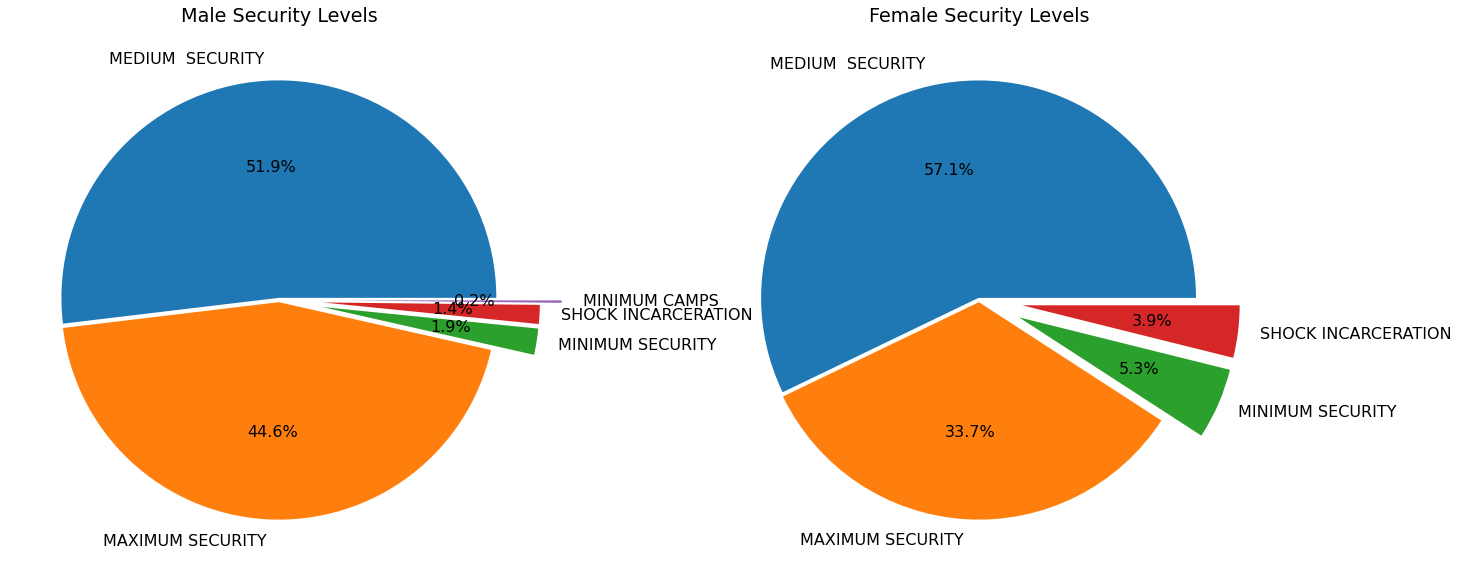

In [18]:
fig = plt.figure(figsize = (23,10))
grid = plt.GridSpec(1,2, hspace = 0.3, wspace = 0.2, figure = fig)

fig.add_subplot(grid[0,0], title = 'Male Security Levels')
plt.pie(male['Facility Security Level'].value_counts(), labels = male['Facility Security Level'].value_counts().keys(), autopct='%1.1f%%', textprops={'fontsize': 16}, explode = (0.01, 0.01, 0.2, 0.2, 0.3));

fig.add_subplot(grid[0,1], title = 'Female Security Levels')
plt.pie(female['Facility Security Level'].value_counts(), labels = female['Facility Security Level'].value_counts().keys(), autopct='%1.1f%%', textprops={'fontsize': 16}, explode = (0.01, 0.01, 0.2, 0.2));

<h1>Detailed Analyses</h1>
Now that large, generalized information has been analyzed, we will look at more specific, granular data to see if any additional interesting information can be found.

<h3>Racial and Gender Statistics</h3>
The most clearly concerning aspect of the general statistics is the obvious over-representation of minority groups in the prison system, with notable differences between men and women as well. Therefore, a closer look to see more detail seems prudent.

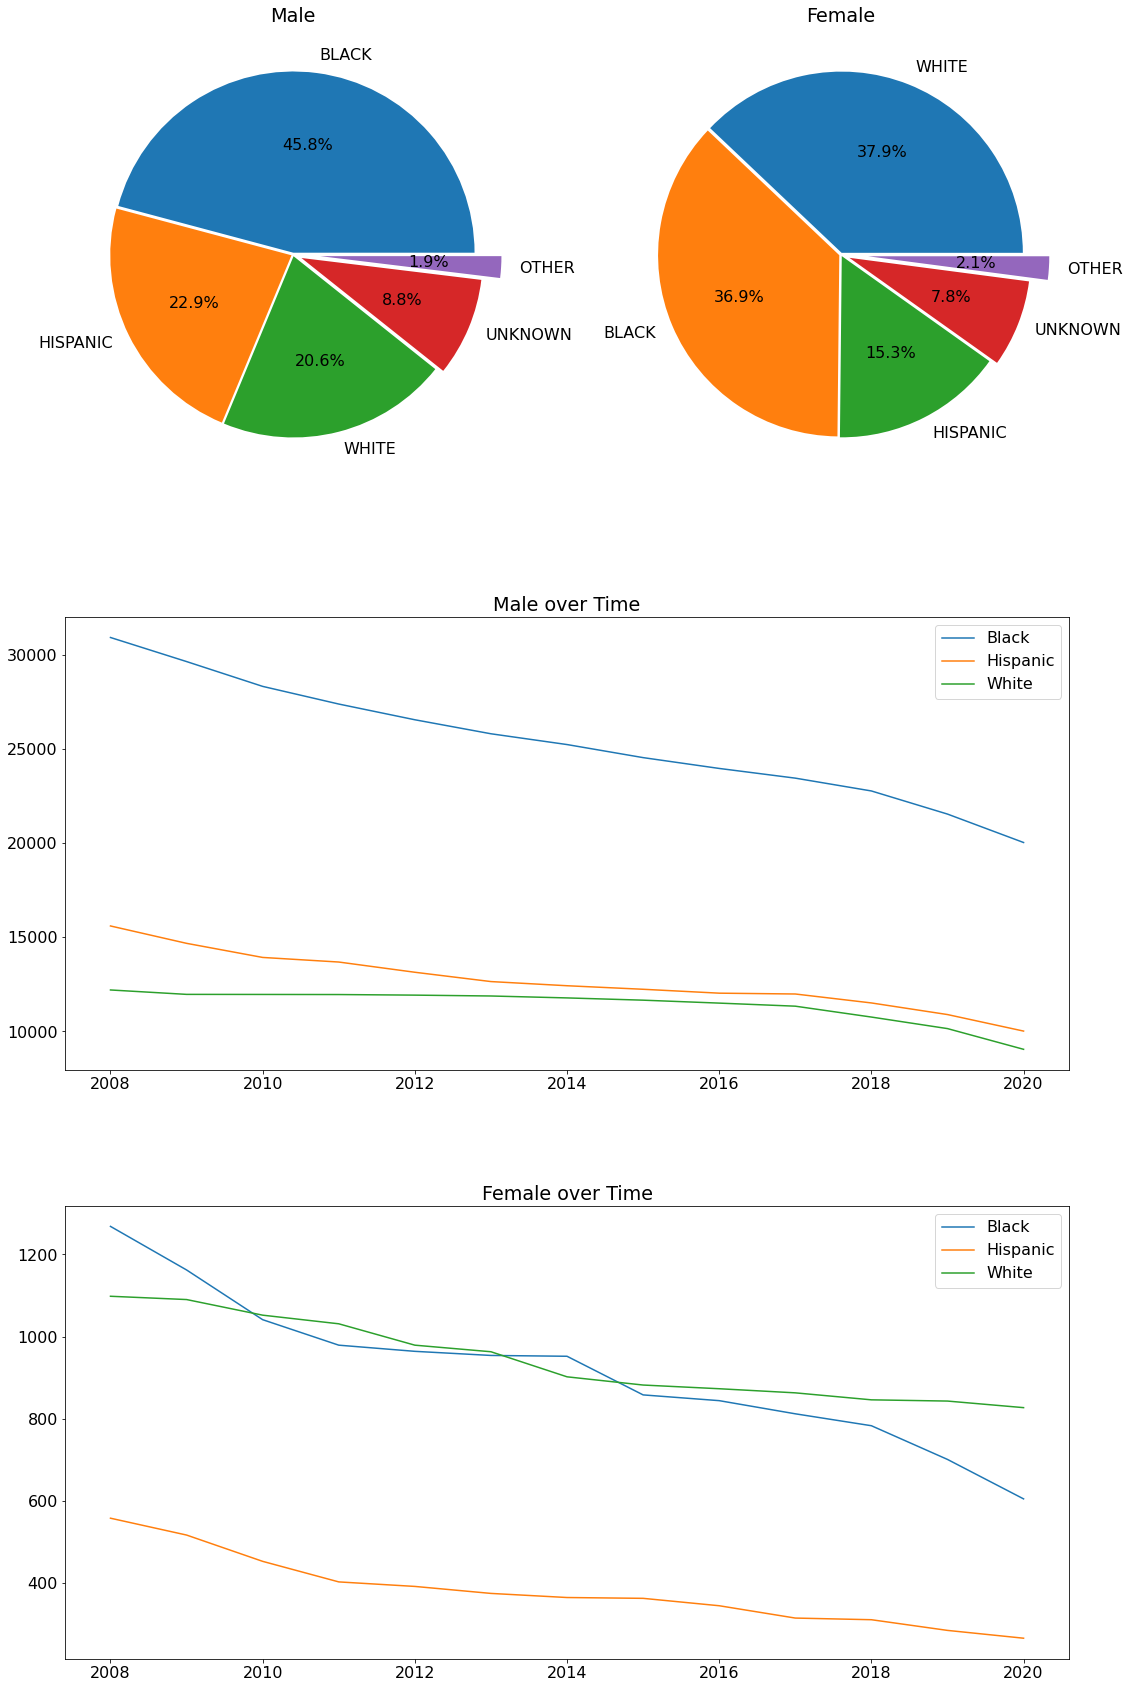

In [19]:
fig = plt.figure(figsize = (18,30))
grid = plt.GridSpec(3,2, hspace = 0.3, wspace = 0.2, figure = fig)

fig.add_subplot(grid[0,0], title = "Male")
plt.pie(male['Race/Ethnicity'].value_counts(), labels = male['Race/Ethnicity'].value_counts().keys(), autopct='%1.1f%%', textprops={'fontsize': 16}, explode = (0.01, 0.01, 0.01, 0.05, 0.15))

fig.add_subplot(grid[0,1], title = "Female")
plt.pie(female['Race/Ethnicity'].value_counts(), labels = female['Race/Ethnicity'].value_counts().keys(), autopct='%1.1f%%', textprops={'fontsize': 16}, explode = (0.01, 0.01, 0.01, 0.05, 0.15));

fig.add_subplot(grid[1,0:], title = "Male over Time")
plt.plot(linbin, blackMale['Snapshot Year'].value_counts(), label = 'Black')
plt.plot(linbin, hispanicMale['Snapshot Year'].value_counts(), label = 'Hispanic')
plt.plot(linbin, whiteMale['Snapshot Year'].value_counts(), label = 'White')
plt.legend()

fig.add_subplot(grid[2,0:], title = "Female over Time")
plt.plot(linbin, blackFemale['Snapshot Year'].value_counts(), label = 'Black')
plt.plot(linbin, hispanicFemale['Snapshot Year'].value_counts(), label = 'Hispanic')
plt.plot(linbin, whiteFemale['Snapshot Year'].value_counts(), label = 'White')
plt.legend();

Based upon the above charts, and some of the general statistics, it would appear that the female commitment rates are far closer than the male ones based upon simply looking at the census for New York, though not quite matching it, it's far closer to being 'variation within reason'. More importantly, the disparity between the Y-Axis scales of the last two charts puts into perspective how large the difference is between male and female commitments. Both charts, fortunately, continue to show the trend of reduced commitments overall, albeit it various rates. Most notably, the over-represention of Blacks and the gap there does appear to be closing.

<AxesSubplot:title={'center':'NY, Normalized for Pop. % (Male)'}, ylabel='Percent'>

<Figure size 1296x2880 with 0 Axes>

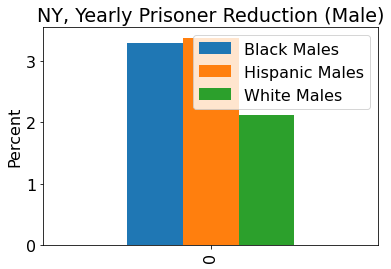

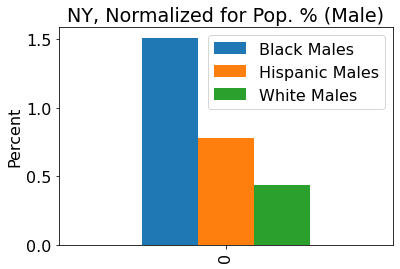

In [104]:
fig = plt.figure(figsize = (18,40))
grid = plt.GridSpec(1,1, hspace = 0.3, wspace = 0.2, figure = fig)

bmValCounts = blackMale['Snapshot Year'].value_counts()
hmValCounts = hispanicMale['Snapshot Year'].value_counts()
wmValCounts = whiteMale['Snapshot Year'].value_counts()
total = bmValCounts.sum() + hmValCounts.sum() + wmValCounts.sum() + maleRaces.get_group('OTHER').value_counts().sum() + maleRaces.get_group('UNKNOWN').value_counts().sum()

slope_d = {'Black Males': [pd.to_numeric((((bmValCounts.iloc[0] - bmValCounts.iloc[12])/13) / (bmValCounts.sum()/bmValCounts.count()))*100)],
     'Hispanic Males': [pd.to_numeric((((hmValCounts.iloc[0] - hmValCounts.iloc[12])/13) / (hmValCounts.sum()/hmValCounts.count()))*100)],
     'White Males': [pd.to_numeric((((wmValCounts.iloc[0] - wmValCounts.iloc[12])/13) / (wmValCounts.sum()/wmValCounts.count()))*100)]}

slope_d2 = {'Black Males': [slope_d['Black Males'][0] * (bmValCounts.sum() / total)], 
     'Hispanic Males': [slope_d['Hispanic Males'][0] * (hmValCounts.sum() / total)],
     'White Males': [slope_d['White Males'][0] * (wmValCounts.sum() / total)]}


slope_df = pd.DataFrame(slope_d)
slopeByPerc = pd.DataFrame(slope_d2)

slope_df.plot(kind = 'bar', title = 'NY, Yearly Prisoner Reduction (Male)', ylabel="Percent")
slopeByPerc.plot(kind = 'bar', title = 'NY, Normalized for Pop. % (Male)',  ylabel="Percent")


The first graph is the average slope for males of the three noted racial/ethnic groups, and in the second chart, it is normalized to see which groups are falling faster per-group without it being skewed by over/under representation in the prison system. Same below, but for females.

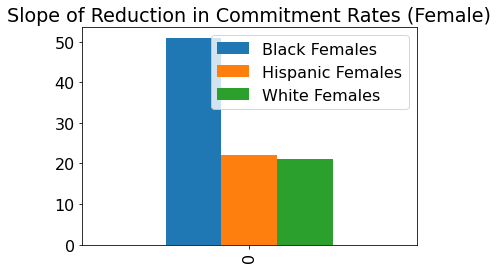

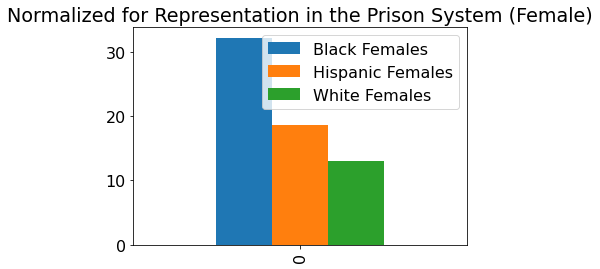

In [13]:
bfValCounts = blackFemale['Snapshot Year'].value_counts()
hfValCounts = hispanicFemale['Snapshot Year'].value_counts()
wfValCounts = whiteFemale['Snapshot Year'].value_counts()
total = bfValCounts.sum() + hfValCounts.sum() + wfValCounts.sum() + femaleRaces.get_group('OTHER').value_counts().sum() + femaleRaces.get_group('UNKNOWN').value_counts().sum()

slope_e = {'Black Females': [round((bfValCounts.iloc[0] - bfValCounts.iloc[12])/13)], 
     'Hispanic Females': [round((hfValCounts.iloc[0] - hfValCounts.iloc[12])/13)],
     'White Females': [round((wfValCounts.iloc[0] - wfValCounts.iloc[12])/13)]}

slope_e2 = {'Black Females': [round((bfValCounts.iloc[0] - bfValCounts.iloc[12])/13) * (1 - bfValCounts.sum() / total)], 
     'Hispanic Females': [round((hfValCounts.iloc[0] - hfValCounts.iloc[12])/13) * (1 - hfValCounts.sum() / total)],
     'White Females': [round((wfValCounts.iloc[0] - wfValCounts.iloc[12])/13) * (1 - wfValCounts.sum() / total)]}

slope_ef = pd.DataFrame(slope_e)
slopeByPerc2 = pd.DataFrame(slope_e2)

slope_ef.plot(kind = 'bar', title = 'Slope of Reduction in Commitment Rates (Female)')
slopeByPerc2.plot(kind = 'bar', title = 'Normalized for Representation in the Prison System (Female)');


While a stacked bar chart may have been more concise for the below data, I believe seeing each pie chart individually allows for a clearer understanding of each subset without the confusion that may come from 9 different partial bars stacked in each category, and for that aggregate understanding we already have a pie chart up above that achieves that. The purpose of this is to drill down on each subset and focus on them individually.

Additionally, legends are used as some of the labels can get pretty long and start causing all sorts of overlap problems.

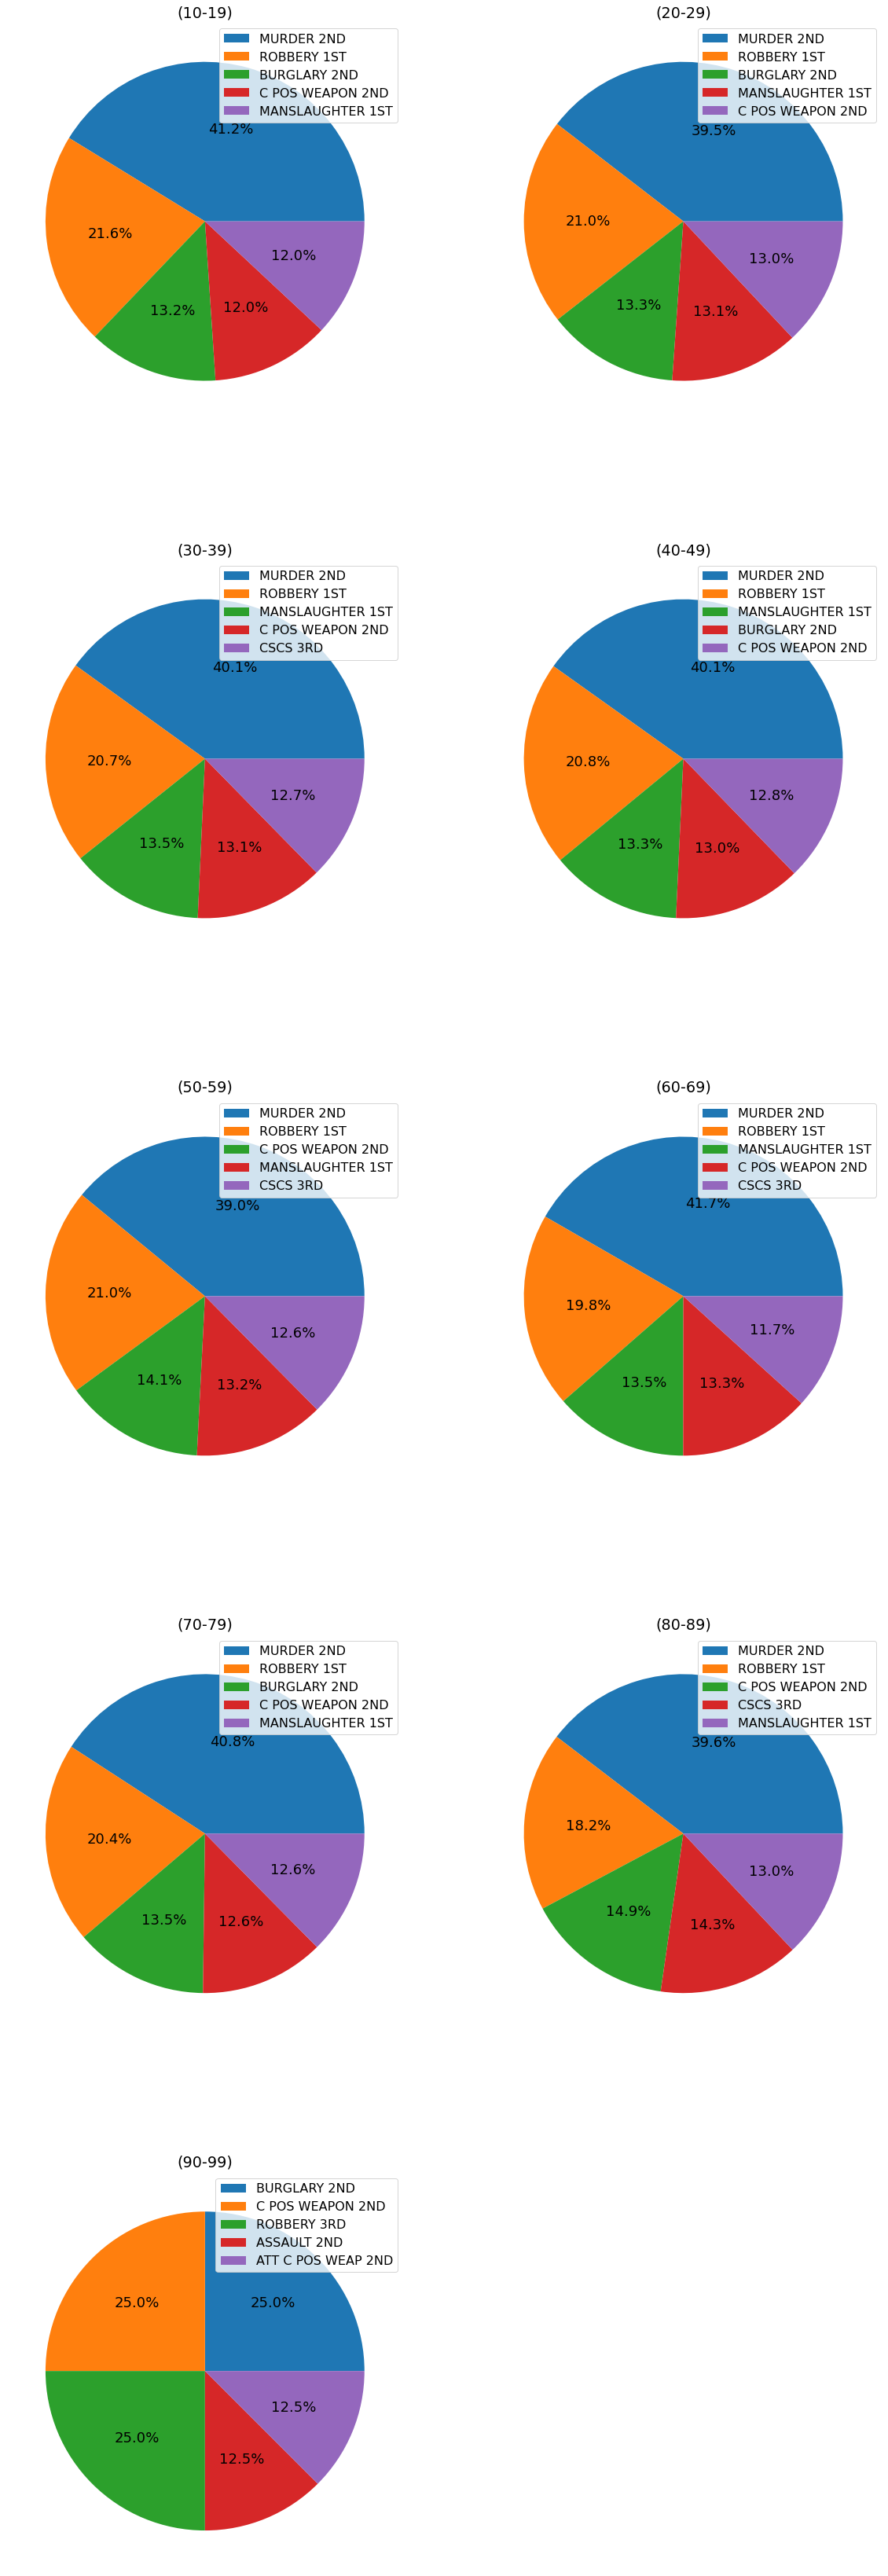

In [14]:
class runCon:
    notRan = True

def ageRanger(x): # Turn specific values into ranges for generalization purposes
    if x.name == 'Current Age':
        retList = []
        runCon.notRan = False
        for val in x:
            lowrange = math.floor(val / 10) * 10
            highrange = lowrange + 9
            retList.append('(' + str(lowrange) + '-' + str(highrange) + ')')
        return pd.Series(retList)
    else:
        return x

fig = plt.figure(figsize = (20,60))
grid = plt.GridSpec(5,2, hspace = 0.3, wspace = 0.2, figure = fig)

maleAge = male.copy()
maleAge = male.apply(ageRanger)
maleAgeCrime = maleAge.groupby(['Current Age', 'Most Serious Crime']).size().reset_index(name = 'Count')
maleAgeCrime = maleAgeCrime.groupby('Current Age') # 9 sets

gridx = 0
gridy = 0

for _, ageFrame in maleAgeCrime:
    ageFrame = ageFrame.sort_values(by = ["Count"], ascending = False)
    fig.add_subplot(grid[gridy,gridx], title = ageFrame['Current Age'].iloc[0])
    plt.pie(ageFrame['Count'].head(5), labels = ageFrame['Most Serious Crime'].head(5), textprops={'fontsize': 18},  labeldistance = None, autopct='%1.1f%%');
    plt.legend()
    
    if gridx == 0:
        gridx += 1
    else:
        gridx = 0
        gridy += 1